In [1]:
# Import libraries and modules
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
print(np.__version__)
print(tf.__version__)
np.set_printoptions(threshold=np.inf)

1.18.5
2.2.0-dlenv


# Local Development

## Arguments

In [2]:
arguments = {}
# File arguments.
arguments["train_file_pattern"] = "gs://machine-learning-1234-bucket/gan/data/mnist/train*.tfrecord"
arguments["eval_file_pattern"] = "gs://machine-learning-1234-bucket/gan/data/mnist/test*.tfrecord"
arguments["output_dir"] = "gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model"

# Training parameters.
arguments["tf_version"] = 2.2
arguments["use_graph_mode"] = True
arguments["distribution_strategy"] = ""
arguments["write_summaries"] = False
arguments["num_epochs"] = 30
arguments["train_dataset_length"] = 60000
arguments["train_batch_size"] = 32
arguments["log_step_count_steps"] = 100
arguments["save_summary_steps"] = 100
arguments["save_checkpoints_steps"] = 10000
arguments["keep_checkpoint_max"] = 10
arguments["input_fn_autotune"] = False

# Eval parameters.
arguments["eval_batch_size"] = 32
arguments["eval_steps"] = 100

# Image parameters.
arguments["height"] = 28
arguments["width"] = 28
arguments["depth"] = 1

# Generator parameters.
arguments["latent_size"] = 512
arguments["generator_hidden_units"] = [256, 512, 1024]
arguments["generator_leaky_relu_alpha"] = 0.2
arguments["generator_final_activation"] = "tanh"
arguments["generator_l1_regularization_scale"] = 0.
arguments["generator_l2_regularization_scale"] = 0.
arguments["generator_optimizer"] = "Adam"
arguments["generator_learning_rate"] = 0.0002
arguments["generator_adam_beta1"] = 0.5
arguments["generator_adam_beta2"] = 0.999
arguments["generator_adam_epsilon"] = 1e-8
arguments["generator_clip_gradients"] = None
arguments["generator_train_steps"] = 1

# Discriminator hyperparameters.
arguments["discriminator_hidden_units"] = [1024, 512, 256]
arguments["discriminator_leaky_relu_alpha"] = 0.2
arguments["discriminator_l1_regularization_scale"] = 0.
arguments["discriminator_l2_regularization_scale"] = 0.
arguments["discriminator_optimizer"] = "Adam"
arguments["discriminator_learning_rate"] = 0.0002
arguments["discriminator_adam_beta1"] = 0.5
arguments["discriminator_adam_beta2"] = 0.999
arguments["discriminator_adam_epsilon"] = 1e-8
arguments["discriminator_clip_gradients"] = None
arguments["discriminator_train_steps"] = 1
arguments["label_smoothing"] = 0.9


## input.py

In [3]:
def preprocess_image(image):
    """Preprocess image tensor.

    Args:
        image: tensor, input image with shape
            [batch_size, height, width, depth].

    Returns:
        Preprocessed image tensor with shape
            [batch_size, height, width, depth].
    """
    # Convert from [0, 255] -> [-1.0, 1.0] floats.
    image = tf.cast(x=image, dtype=tf.float32) * (2. / 255) - 1.0

    return image


def decode_example(protos, params):
    """Decodes TFRecord file into tensors.

    Given protobufs, decode into image and label tensors.

    Args:
        protos: protobufs from TFRecord file.
        params: dict, user passed parameters.

    Returns:
        Image and label tensors.
    """
    # Create feature schema map for protos.
    features = {
        "image_raw": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
        "label": tf.io.FixedLenFeature(shape=[], dtype=tf.int64)
    }

    # Parse features from tf.Example.
    parsed_features = tf.io.parse_single_example(
        serialized=protos, features=features
    )

    # Convert from a scalar string tensor (whose single string has
    # length height * width * depth) to a uint8 tensor with shape
    # [height * width * depth].
    image = tf.io.decode_raw(
        input_bytes=parsed_features["image_raw"], out_type=tf.uint8
    )

    # Reshape flattened image back into normal dimensions.
    image = tf.reshape(
        tensor=image,
        shape=[params["height"], params["width"], params["depth"]]
    )

    # Preprocess image.
    image = preprocess_image(image=image)

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(x=parsed_features["label"], dtype=tf.int32)

    return {"image": image}, label


def read_dataset(filename, batch_size, params, training):
    """Reads TF Record data using tf.data, doing necessary preprocessing.

    Given filename, mode, batch size, and other parameters, read TF Record
    dataset using Dataset API, apply necessary preprocessing, and return an
    input function to the Estimator API.

    Args:
        filename: str, file pattern that to read into our tf.data dataset.
        batch_size: int, number of examples per batch.
        params: dict, dictionary of user passed parameters.
        training: bool, if training or not.

    Returns:
        An input function.
    """
    def _input_fn():
        """Wrapper input function used by Estimator API to get data tensors.

        Returns:
            Batched dataset object of dictionary of feature tensors and label
                tensor.
        """
        # Create list of files that match pattern.
        file_list = tf.data.Dataset.list_files(file_pattern=filename)

        # Create dataset from file list.
        dataset = tf.data.TFRecordDataset(
            filenames=file_list,
            num_parallel_reads=(
                tf.contrib.data.AUTOTUNE
                if params["input_fn_autotune"]
                else None
            )
        )

        # Shuffle and repeat if training with fused op.
        if training:
            dataset = dataset.apply(
                tf.data.experimental.shuffle_and_repeat(
                    buffer_size=50 * batch_size,
                    count=None  # indefinitely
                )
            )

        # Decode CSV file into a features dictionary of tensors, then batch.
        dataset = dataset.apply(
            tf.data.experimental.map_and_batch(
                map_func=lambda x: decode_example(
                    protos=x,
                    params=params
                ),
                batch_size=batch_size,
                num_parallel_calls=(
                    tf.contrib.data.AUTOTUNE
                    if params["input_fn_autotune"]
                    else None
                )
            )
        )

        # Prefetch data to improve latency.
        dataset = dataset.prefetch(
            buffer_size=(
                tf.data.experimental.AUTOTUNE
                if params["input_fn_autotune"]
                else 1
            )
        )

        return dataset
    return _input_fn


In [4]:
train_ds = read_dataset(
    filename=arguments["train_file_pattern"],
    batch_size=arguments["train_batch_size"],
    params=arguments,
    training=True
)()
train_ds

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ({image: (None, 28, 28, 1)}, (None,)), types: ({image: tf.float32}, tf.int32)>

In [5]:
eval_ds = read_dataset(
    filename=arguments["eval_file_pattern"],
    batch_size=arguments["eval_batch_size"],
    params=arguments,
    training=False
)()
eval_ds

<PrefetchDataset shapes: ({image: (None, 28, 28, 1)}, (None,)), types: ({image: tf.float32}, tf.int32)>

## generator.py

In [6]:
class Generator(object):
    """Generator that takes latent vector input and outputs image.

    Fields:
        name: str, name of `Generator`.
        params: dict, user passed parameters.
        model: instance of generator `Model`.
    """
    def __init__(
            self,
            input_shape,
            kernel_regularizer,
            bias_regularizer,
            name,
            params):
        """Instantiates and builds generator network.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
            kernel_regularizer: `l1_l2_regularizer` object, regularizar for
                kernel variables.
            bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
                variables.
            name: str, name of generator.
            params: dict, user passed parameters.
        """
        # Set name of generator.
        self.name = name

        self.params = params

        # Instantiate generator `Model`.
        self.model = self._define_generator(
            input_shape, kernel_regularizer, bias_regularizer
        )

    def _define_generator(
            self, input_shape, kernel_regularizer, bias_regularizer):
        """Defines generator network.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
            kernel_regularizer: `l1_l2_regularizer` object, regularizar for
                kernel variables.
            bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
                variables.

        Returns:
            Instance of `Model` object.
        """
        # Create the input layer to generator.
        # shape = (batch_size, latent_size)
        inputs = tf.keras.Input(
            shape=input_shape, name="{}_inputs".format(self.name)
        )
        network = inputs

        # Dictionary containing possible final activations.
        final_activation_set = {"sigmoid", "relu", "tanh"}

        # Add hidden layers with given number of units/neurons per layer.
        for i, units in enumerate(self.params["generator_hidden_units"]):
            # shape = (batch_size, generator_hidden_units[i])
            network = tf.keras.layers.Dense(
                units=units,
                activation=None,
                kernel_regularizer=kernel_regularizer,
                bias_regularizer=bias_regularizer,
                name="{}_layers_dense_{}".format(self.name, i)
            )(inputs=network)

            network = tf.keras.layers.LeakyReLU(
                alpha=self.params["generator_leaky_relu_alpha"],
                name="{}_leaky_relu_{}".format(self.name, i)
            )(inputs=network)

        # Final linear layer for outputs.
        # shape = (batch_size, height * width * depth)
        generated_outputs = tf.keras.layers.Dense(
            units=self.params["height"] * self.params["width"] * self.params["depth"],
            activation=(
                self.params["generator_final_activation"].lower()
                if self.params["generator_final_activation"].lower()
                in final_activation_set
                else None
            ),
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            name="{}_layers_dense_generated_outputs".format(self.name)
        )(inputs=network)

        # Define model.
        model = tf.keras.Model(
            inputs=inputs, outputs=generated_outputs, name=self.name
        )

        return model

    def get_model(self):
        """Returns generator's `Model` object.

        Returns:
            Generator's `Model` object.
        """
        return self.model

    def get_generator_loss(
        self,
        global_batch_size,
        fake_logits,
        global_step,
        summary_file_writer
    ):
        """Gets generator loss.

        Args:
            global_batch_size: int, global batch size for distribution.
            fake_logits: tensor, shape of
                [batch_size, 1].
            global_step: int, current global step for training.
            summary_file_writer: summary file writer.

        Returns:
            Tensor of generator's total loss of shape [].
        """
        if self.params["distribution_strategy"]:
            # Calculate base generator loss.
            generator_loss = tf.nn.compute_average_loss(
                per_example_loss=tf.keras.losses.BinaryCrossentropy(
                    from_logits=True,
                    reduction=tf.keras.losses.Reduction.NONE
                )(
                    y_true=tf.ones_like(input=fake_logits), y_pred=fake_logits
                ),
                global_batch_size=global_batch_size
            )

            # Get regularization losses.
            generator_reg_loss = tf.nn.scale_regularization_loss(
                regularization_loss=sum(self.model.losses)
            )
        else:
            # Calculate base generator loss.
            generator_loss = tf.keras.losses.BinaryCrossentropy(
                from_logits=True
            )(
                y_true=tf.ones_like(input=fake_logits), y_pred=fake_logits
            )

            # Get regularization losses.
            generator_reg_loss = sum(self.model.losses)

        # Combine losses for total losses.
        generator_total_loss = tf.math.add(
            x=generator_loss,
            y=generator_reg_loss,
            name="generator_total_loss"
        )

        if self.params["write_summaries"]:
            # Add summaries for TensorBoard.
            with summary_file_writer.as_default():
                with tf.summary.record_if(
                    condition=tf.equal(
                        x=tf.math.floormod(
                            x=global_step,
                            y=self.params["save_summary_steps"]
                        ), y=0
                    )
                ):
                    tf.summary.scalar(
                        name="losses/generator_loss",
                        data=generator_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/generator_reg_loss",
                        data=generator_reg_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="optimized_losses/generator_total_loss",
                        data=generator_total_loss,
                        step=global_step
                    )
                    summary_file_writer.flush()

        return generator_total_loss


In [7]:
# Instantiate generator.
vanilla_generator = Generator(
    input_shape=(arguments["latent_size"]),
    kernel_regularizer=tf.keras.regularizers.l1_l2(
        l1=arguments["generator_l1_regularization_scale"],
        l2=arguments["generator_l2_regularization_scale"]
    ),
    bias_regularizer=None,
    name="generator",
    params=arguments
)

# Define generator model.
generator_model = vanilla_generator.get_model()

In [8]:
# Summarize generator model.
generator_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_inputs (InputLayer [(None, 512)]             0         
_________________________________________________________________
generator_layers_dense_0 (De (None, 256)               131328    
_________________________________________________________________
generator_leaky_relu_0 (Leak (None, 256)               0         
_________________________________________________________________
generator_layers_dense_1 (De (None, 512)               131584    
_________________________________________________________________
generator_leaky_relu_1 (Leak (None, 512)               0         
_________________________________________________________________
generator_layers_dense_2 (De (None, 1024)              525312    
_________________________________________________________________
generator_leaky_relu_2 (Leak (None, 1024)              0 

In [9]:
generator_model.__dict__

{'_self_setattr_tracking': True,
 '_nested_outputs': <tf.Tensor 'generator_layers_dense_generated_outputs/Identity:0' shape=(None, 784) dtype=float32>,
 '_nested_inputs': <tf.Tensor 'generator_inputs:0' shape=(None, 512) dtype=float32>,
 'inputs': [<tf.Tensor 'generator_inputs:0' shape=(None, 512) dtype=float32>],
 'outputs': [<tf.Tensor 'generator_layers_dense_generated_outputs/Identity:0' shape=(None, 784) dtype=float32>],
 '_enable_dict_to_input_mapping': True,
 '_trainable': True,
 '_stateful': False,
 'built': True,
 '_build_input_shape': TensorShape([None, 512]),
 '_input_spec': None,
 'supports_masking': False,
 '_supports_ragged_inputs': None,
 '_name': 'generator',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x7ff9800be6b0>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7ff98033e9c0>,
 '_dtype_policy': <Policy "flo

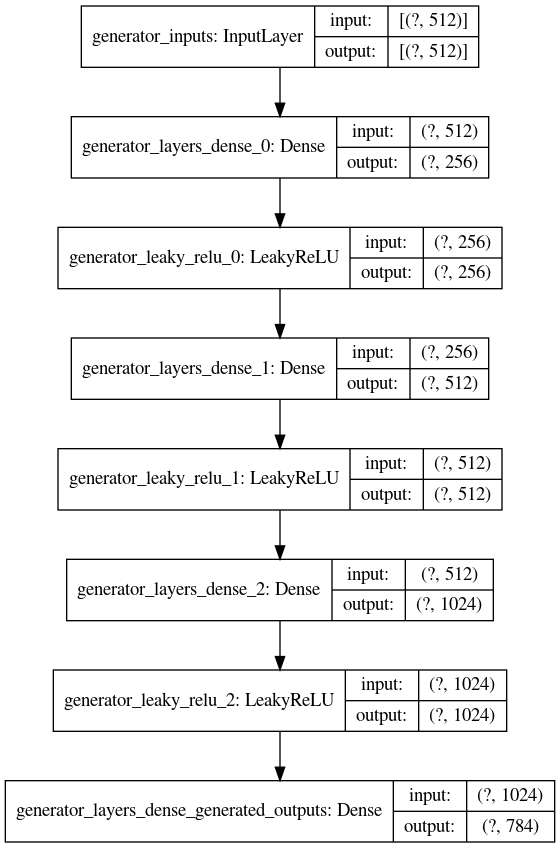

In [10]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=generator_model,
    to_file="generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

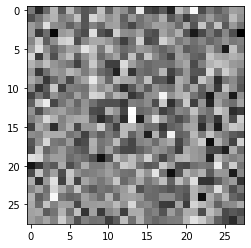

In [11]:
noise = tf.random.normal(shape=[10, arguments["latent_size"]])
generated_outputs = generator_model(inputs=noise, training=False)
generated_images = tf.reshape(
    tensor=generated_outputs,
    shape=[-1, arguments["height"], arguments["width"], arguments["depth"]]
)

plt.imshow(generated_images[0, :, :, 0], cmap='gray')

## discriminator.py

In [12]:
class Discriminator(object):
    """Discriminator that takes image input and outputs logits.

    Fields:
        name: str, name of `Discriminator`.
        params: dict, user passed parameters.
        model: instance of discriminator `Model`.
    """
    def __init__(
            self,
            input_shape,
            kernel_regularizer,
            bias_regularizer,
            name,
            params):
        """Instantiates and builds discriminator network.

        Args:
            input_shape: tuple, shape of image vector input of shape
                [batch_size, height * width * depth].
            kernel_regularizer: `l1_l2_regularizer` object, regularizar for
                kernel variables.
            bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
                variables.
            name: str, name of discriminator.
            params: dict, user passed parameters.
        """
        # Set name of discriminator.
        self.name = name

        self.params = params

        # Instantiate discriminator `Model`.
        self.model = self._define_discriminator(
            input_shape, kernel_regularizer, bias_regularizer
        )

    def _define_discriminator(
            self, input_shape, kernel_regularizer, bias_regularizer):
        """Defines discriminator network.

        Args:
            input_shape: tuple, shape of image vector input of shape
                [batch_size, height * width * depth].
            kernel_regularizer: `l1_l2_regularizer` object, regularizar for
                kernel variables.
            bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
                variables.

        Returns:
            Instance of `Model` object.
        """
        # Create the input layer to discriminator.
        # shape = (batch_size, height * width * depth)
        inputs = tf.keras.Input(
            shape=input_shape,
            name="{}_inputs".format(self.name)
        )
        network = inputs

        # Add hidden layers with given number of units/neurons per layer.
        for i, units in enumerate(self.params["discriminator_hidden_units"]):
            # shape = (batch_size, discriminator_hidden_units[i])
            network = tf.keras.layers.Dense(
                units=units,
                activation=None,
                kernel_regularizer=kernel_regularizer,
                bias_regularizer=bias_regularizer,
                name="{}_layers_dense_{}".format(self.name, i)
            )(inputs=network)

            network = tf.keras.layers.LeakyReLU(
                alpha=self.params["discriminator_leaky_relu_alpha"],
                name="{}_leaky_relu_{}".format(self.name, i)
            )(inputs=network)

        # Final linear layer for logits.
        # shape = (batch_size, 1)
        logits = tf.keras.layers.Dense(
            units=1,
            activation=None,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            name="{}_layers_dense_logits".format(self.name)
        )(inputs=network)

        # Define model.
        model = tf.keras.Model(
            inputs=inputs, outputs=logits, name=self.name
        )

        return model

    def get_model(self):
        """Returns discriminator's `Model` object.

        Returns:
            Discriminator's `Model` object.
        """
        return self.model

    def get_discriminator_loss(
        self,
        global_batch_size,
        fake_logits,
        real_logits,
        global_step,
        summary_file_writer
    ):
        """Gets discriminator loss.

        Args:
            global_batch_size: int, global batch size for distribution.
            fake_logits: tensor, shape of
                [batch_size, 1].
            real_logits: tensor, shape of
                [batch_size, 1].
            global_step: int, current global step for training.
            summary_file_writer: summary file writer.

        Returns:
            Tensor of discriminator's total loss of shape [].
        """
        if self.params["distribution_strategy"]:
            # Calculate base discriminator loss.
            discriminator_real_loss = tf.nn.compute_average_loss(
                per_example_loss=tf.keras.losses.BinaryCrossentropy(
                    from_logits=True,
                    label_smoothing=self.params["label_smoothing"],
                    reduction=tf.keras.losses.Reduction.NONE
                )(
                    y_true=tf.ones_like(input=real_logits), y_pred=real_logits
                ),
                global_batch_size=global_batch_size
            )

            discriminator_fake_loss = tf.nn.compute_average_loss(
                per_example_loss=tf.keras.losses.BinaryCrossentropy(
                    from_logits=True,
                    reduction=tf.keras.losses.Reduction.NONE
                )(
                    y_true=tf.zeros_like(input=fake_logits), y_pred=fake_logits
                ),
                global_batch_size=global_batch_size
            )
        else:
            # Calculate base discriminator loss.
            discriminator_real_loss = tf.keras.losses.BinaryCrossentropy(
                from_logits=True,
                label_smoothing=self.params["label_smoothing"]
            )(
                y_true=tf.ones_like(input=real_logits), y_pred=real_logits
            )

            discriminator_fake_loss = tf.keras.losses.BinaryCrossentropy(
                from_logits=True
            )(
                y_true=tf.zeros_like(input=fake_logits), y_pred=fake_logits
            )

        discriminator_loss = tf.add(
            x=discriminator_real_loss,
            y=discriminator_fake_loss,
            name="discriminator_loss"
        )

        if self.params["distribution_strategy"]:
            # Get regularization losses.
            discriminator_reg_loss = tf.nn.scale_regularization_loss(
                regularization_loss=sum(self.model.losses)
            )
        else:
            # Get regularization losses.
            discriminator_reg_loss = sum(self.model.losses)

        # Combine losses for total losses.
        discriminator_total_loss = tf.math.add(
            x=discriminator_loss,
            y=discriminator_reg_loss,
            name="discriminator_total_loss"
        )

        if self.params["write_summaries"]:
            # Add summaries for TensorBoard.
            with summary_file_writer.as_default():
                with tf.summary.record_if(
                    condition=tf.equal(
                        x=tf.math.floormod(
                            x=global_step,
                            y=self.params["save_summary_steps"]
                        ), y=0
                    )
                ):
                    tf.summary.scalar(
                        name="losses/discriminator_real_loss",
                        data=discriminator_real_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/discriminator_fake_loss",
                        data=discriminator_fake_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/discriminator_loss",
                        data=discriminator_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/discriminator_reg_loss",
                        data=discriminator_reg_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="optimized_losses/discriminator_total_loss",
                        data=discriminator_total_loss,
                        step=global_step
                    )
                    summary_file_writer.flush()

        return discriminator_total_loss


In [13]:
# Instantiate discriminator.
vanilla_discriminator = Discriminator(
    input_shape=(arguments["height"] * arguments["width"] * arguments["depth"]),
    kernel_regularizer=tf.keras.regularizers.l1_l2(
        l1=arguments["discriminator_l1_regularization_scale"],
        l2=arguments["discriminator_l2_regularization_scale"]
    ),
    bias_regularizer=None,
    name="discriminator",
    params=arguments
)

# Define discriminator model.
discriminator_model = vanilla_discriminator.get_model()

In [14]:
# Summarize discriminator model.
discriminator_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_inputs (InputL [(None, 784)]             0         
_________________________________________________________________
discriminator_layers_dense_0 (None, 1024)              803840    
_________________________________________________________________
discriminator_leaky_relu_0 ( (None, 1024)              0         
_________________________________________________________________
discriminator_layers_dense_1 (None, 512)               524800    
_________________________________________________________________
discriminator_leaky_relu_1 ( (None, 512)               0         
_________________________________________________________________
discriminator_layers_dense_2 (None, 256)               131328    
_________________________________________________________________
discriminator_leaky_relu_2 ( (None, 256)             

In [15]:
discriminator_model.__dict__

{'_self_setattr_tracking': True,
 '_nested_outputs': <tf.Tensor 'discriminator_layers_dense_logits/Identity:0' shape=(None, 1) dtype=float32>,
 '_nested_inputs': <tf.Tensor 'discriminator_inputs:0' shape=(None, 784) dtype=float32>,
 'inputs': [<tf.Tensor 'discriminator_inputs:0' shape=(None, 784) dtype=float32>],
 'outputs': [<tf.Tensor 'discriminator_layers_dense_logits/Identity:0' shape=(None, 1) dtype=float32>],
 '_enable_dict_to_input_mapping': True,
 '_trainable': True,
 '_stateful': False,
 'built': True,
 '_build_input_shape': TensorShape([None, 784]),
 '_input_spec': None,
 'supports_masking': False,
 '_supports_ragged_inputs': None,
 '_name': 'discriminator',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x7ff98026b470>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7ff980302cc0>,
 '_dtype_policy': <Policy "float32",

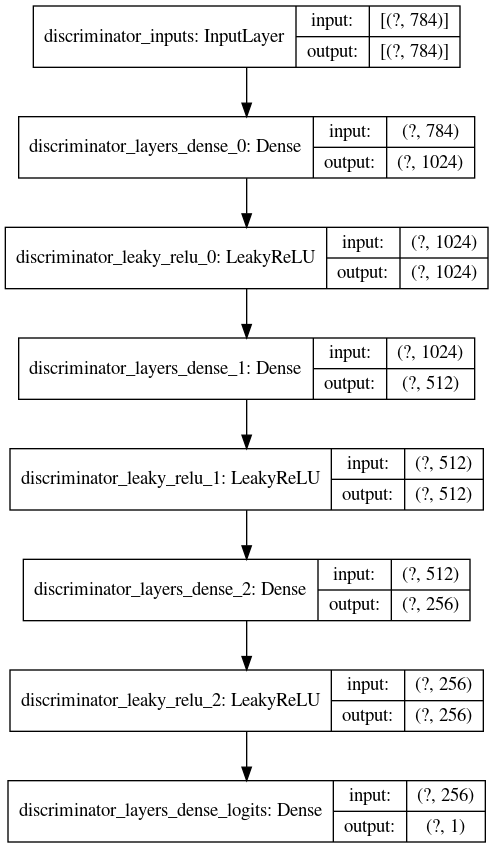

In [16]:
# Plot discriminator model.
tf.keras.utils.plot_model(
    model=discriminator_model,
    to_file="discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [17]:
images = tf.random.normal(
    shape=[10, arguments["height"] * arguments["width"] * arguments["depth"]]
)
logits = discriminator_model(inputs=images, training=False)
logits.shape

TensorShape([10, 1])

## train_and_evaluate_loop.py

In [18]:
class TrainAndEvaluateLoop(tf.keras.Model):
    """Train and evaluate loop trainer.

    Fields:
        params: dict, user passed parameters.
        network_objects: dict, instances of `Generator` and `Discriminator`
            network objects.
        network_models: dict, instances of Keras `Model`s for each network.
        optimizers: dict, instances of Keras `Optimizer`s for each network.
        strategy: instance of `tf.distribute.Strategy`.
        checkpoint_manager: instance of `CheckpointManager`.
        global_batch_size: int, the global batch size after summing batch
            sizes across replicas.
        global_step: tf.Variable, the global step counter across epochs and steps
            within epoch.
        summary_file_writer: instance of tf.summary.create_file_writer for
            summaries for TensorBoard.
    """
    def __init__(self, params):
        """Instantiate trainer.

        Args:
            params: dict, user passed parameters.
        """
        super().__init__()
        self.params = params

        self.network_objects = {}
        self.network_models = {}
        self.optimizers = {}

        self.strategy = None
        self.checkpoint_manager = None

        self.global_batch_size = None
        self.global_step = tf.Variable(
            initial_value=tf.zeros(shape=[], dtype=tf.int64),
            trainable=False,
            name="global_step"
        )
        self.summary_file_writer = None

    # train_and_eval.py
    def generator_loss_phase(self, mode, training):
        """Gets fake logits and loss for generator.

        Args:
            mode: str, what mode currently in: TRAIN or EVAL.
            training: bool, if model should be training.

        Returns:
            Fake logits of shape [batch_size, 1] and generator loss of shape
                [].
        """
        batch_size = (
            self.params["train_batch_size"]
            if mode == "TRAIN"
            else self.params["eval_batch_size"]
        )

        # Create random noise latent vector for each batch example.
        Z = tf.random.normal(
            shape=[batch_size, self.params["latent_size"]],
            mean=0.0,
            stddev=1.0,
            dtype=tf.float32
        )

        # Get generated image from generator network from gaussian noise.
        fake_images = self.network_models["generator"](
            inputs=Z, training=training
        )

        if self.params["write_summaries"] and mode == "TRAIN":
            # Add summaries for TensorBoard.
            with self.summary_file_writer.as_default():
                with tf.summary.record_if(
                condition=tf.equal(
                    x=tf.math.floormod(
                        x=self.global_step,
                        y=self.params["save_summary_steps"]
                    ), y=0
                )
                ):
                    tf.summary.image(
                        name="fake_images",
                        data=tf.reshape(
                            tensor=fake_images,
                            shape=[
                                -1,
                                self.params["height"],
                                self.params["width"],
                                self.params["depth"]
                            ]
                        ),
                        step=self.global_step,
                        max_outputs=5
                    )
                    self.summary_file_writer.flush()

        # Get fake logits from discriminator using generator's output image.
        fake_logits = self.network_models["discriminator"](
            inputs=fake_images, training=training
        )

        # Get generator total loss.
        generator_total_loss = (
            self.network_objects["generator"].get_generator_loss(
                global_batch_size=self.global_batch_size,
                fake_logits=fake_logits,
                global_step=self.global_step,
                summary_file_writer=self.summary_file_writer
            )
        )

        return fake_logits, generator_total_loss

    def discriminator_loss_phase(self, real_images, fake_logits, training):
        """Gets real logits and loss for discriminator.

        Args:
            real_images: tensor, real images of shape
                [batch_size, height * width * depth].
            fake_logits: tensor, discriminator logits of fake images of shape
                [batch_size, 1].
            training: bool, if in training mode.

        Returns:
            Real logits of shape [batch_size, 1] and discriminator loss of
                shape [].
        """
        # Get real logits from discriminator using real image.
        real_logits = self.network_models["discriminator"](
            inputs=real_images, training=training
        )

        # Get discriminator total loss.
        discriminator_total_loss = (
            self.network_objects["discriminator"].get_discriminator_loss(
                global_batch_size=self.global_batch_size,
                fake_logits=fake_logits,
                real_logits=real_logits,
                global_step=self.global_step,
                summary_file_writer=self.summary_file_writer
            )
        )

        return real_logits, discriminator_total_loss

    # train.py
    def get_variables_and_gradients(self, loss, gradient_tape, scope):
        """Gets variables and gradients from model wrt. loss.

        Args:
            loss: tensor, shape of [].
            gradient_tape: instance of `GradientTape`.
            scope: str, the name of the network of interest.

        Returns:
            Lists of network's variables and gradients.
        """
        # Get trainable variables.
        variables = self.network_models[scope].trainable_variables

        # Get gradients from gradient tape.
        gradients = gradient_tape.gradient(
            target=loss, sources=variables
        )

        # Clip gradients.
        if self.params["{}_clip_gradients".format(scope)]:
            gradients, _ = tf.clip_by_global_norm(
                t_list=gradients,
                clip_norm=params["{}_clip_gradients".format(scope)],
                name="{}_clip_by_global_norm_gradients".format(scope)
            )

        # Add variable names back in for identification.
        gradients = [
            tf.identity(
                input=g,
                name="{}_{}_gradients".format(scope, v.name[:-2])
            )
            if tf.is_tensor(x=g) else g
            for g, v in zip(gradients, variables)
        ]

        return variables, gradients

    def create_variable_and_gradient_histogram_summaries(
        self, variables, gradients, scope
    ):
        """Creates variable and gradient histogram summaries.

        Args:
            variables: list, network's trainable variables.
            gradients: list, gradients of network's trainable variables wrt.
                loss.
            scope: str, the name of the network of interest.
        """
        if self.params["write_summaries"]:
            # Add summaries for TensorBoard.
            with self.summary_file_writer.as_default():
                with tf.summary.record_if(
                    condition=tf.equal(
                        x=tf.math.floormod(
                            x=self.global_step,
                            y=self.params["save_summary_steps"]
                        ), y=0
                    )
                ):
                    for v, g in zip(variables, gradients):
                        tf.summary.histogram(
                            name="{}_variables/{}".format(
                                scope, v.name[:-2]
                            ),
                            data=v,
                            step=self.global_step
                        )
                        if tf.is_tensor(x=g):
                            tf.summary.histogram(
                                name="{}_gradients/{}".format(
                                    scope, v.name[:-2]
                                ),
                                data=g,
                                step=self.global_step
                            )
                    self.summary_file_writer.flush()

    def get_select_loss_variables_and_gradients(self, real_images, scope):
        """Gets selected network's loss, variables, and gradients.

        Args:
            real_images: tensor, real images of shape
                [batch_size, height * width * depth].
            scope: str, the name of the network of interest.

        Returns:
            Selected network's loss, variables, and gradients.
        """
        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            # Get fake logits from generator.
            fake_logits, generator_loss = self.generator_loss_phase(
                mode="TRAIN", training=True
            )

            # Get discriminator loss.
            _, discriminator_loss = self.discriminator_loss_phase(
                real_images, fake_logits, training=True
            )

        # Create empty dicts to hold loss, variables, gradients.
        loss_dict = {}
        vars_dict = {}
        grads_dict = {}

        # Loop over generator and discriminator.
        for (loss, gradient_tape, scope_name) in zip(
            [generator_loss, discriminator_loss],
            [gen_tape, dis_tape],
            ["generator", "discriminator"]
        ):
            # Get variables and gradients from generator wrt. loss.
            variables, gradients = self.get_variables_and_gradients(
                loss, gradient_tape, scope_name
            )

            # Add loss, variables, and gradients to dictionaries.
            loss_dict[scope_name] = loss
            vars_dict[scope_name] = variables
            grads_dict[scope_name] = gradients

            # Create variable and gradient histogram summaries.
            self.create_variable_and_gradient_histogram_summaries(
                variables, gradients, scope_name
            )

        return loss_dict[scope], vars_dict[scope], grads_dict[scope]

    def train_network(self, variables, gradients, scope):
        """Trains network variables using gradients with optimizer.

        Args:
            variables: list, network's trainable variables.
            gradients: list, gradients of network's trainable variables wrt.
                loss.
            scope: str, the name of the network of interest.
        """
        # Zip together gradients and variables.
        grads_and_vars = zip(gradients, variables)

        # Applying gradients to variables using optimizer.
        self.optimizers[scope].apply_gradients(grads_and_vars=grads_and_vars)

    def train_discriminator(self, features):
        """Trains discriminator network.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Discriminator loss tensor.
        """
        # Extract real images from features dictionary.
        real_images = tf.reshape(
            tensor=features["image"],
            shape=[
                -1,
                self.params["height"] * self.params["width"] * self.params["depth"]
            ]
        )

        # Get gradients for training by running inputs through networks.
        loss, variables, gradients = (
            self.get_select_loss_variables_and_gradients(
                real_images, scope="discriminator"
            )
        )

        # Train discriminator network.
        self.train_network(variables, gradients, scope="discriminator")

        return loss

    def train_generator(self, features):
        """Trains generator network.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Generator loss tensor.
        """
        # Extract real images from features dictionary.
        real_images = tf.reshape(
            tensor=features["image"],
            shape=[
                -1,
                self.params["height"] * self.params["width"] * self.params["depth"]
            ]
        )

        # Get gradients for training by running inputs through networks.
        loss, variables, gradients = (
            self.get_select_loss_variables_and_gradients(
                real_images, scope="generator"
            )
        )

        # Train generator network.
        self.train_network(variables, gradients, scope="generator")

        return loss

    # vanilla_gan.py
    def instantiate_network_objects(self):
        """Instantiates generator and discriminator with parameters.
        """
        # Instantiate generator.
        self.network_objects["generator"] = Generator(
            input_shape=(self.params["latent_size"]),
            kernel_regularizer=tf.keras.regularizers.l1_l2(
                l1=self.params["generator_l1_regularization_scale"],
                l2=self.params["generator_l2_regularization_scale"]
            ),
            bias_regularizer=None,
            name="generator",
            params=self.params
        )

        # Instantiate discriminator.
        self.network_objects["discriminator"] = Discriminator(
            input_shape=(
                self.params["height"] * self.params["width"] * self.params["depth"]
            ),
            kernel_regularizer=tf.keras.regularizers.l1_l2(
                l1=self.params["discriminator_l1_regularization_scale"],
                l2=self.params["discriminator_l2_regularization_scale"]
            ),
            bias_regularizer=None,
            name="discriminator",
            params=self.params
        )

    def instantiate_optimizer(self, scope):
        """Instantiates optimizer with parameters.

        Args:
            scope: str, the name of the network of interest.
        """
        # Create optimizer map.
        optimizers = {
            "Adadelta": tf.keras.optimizers.Adadelta,
            "Adagrad": tf.keras.optimizers.Adagrad,
            "Adam": tf.keras.optimizers.Adam,
            "Adamax": tf.keras.optimizers.Adamax,
            "Ftrl": tf.keras.optimizers.Ftrl,
            "Nadam": tf.keras.optimizers.Nadam,
            "RMSprop": tf.keras.optimizers.RMSprop,
            "SGD": tf.keras.optimizers.SGD
        }

        # Get optimizer and instantiate it.
        if self.params["{}_optimizer".format(scope)] == "Adam":
            optimizer = optimizers[self.params["{}_optimizer".format(scope)]](
                learning_rate=self.params["{}_learning_rate".format(scope)],
                beta_1=self.params["{}_adam_beta1".format(scope)],
                beta_2=self.params["{}_adam_beta2".format(scope)],
                epsilon=self.params["{}_adam_epsilon".format(scope)],
                name="{}_{}_optimizer".format(
                    scope, self.params["{}_optimizer".format(scope)].lower()
                )
            )
        else:
            optimizer = optimizers[self.params["{}_optimizer".format(scope)]](
                learning_rate=self.params["{}_learning_rate".format(scope)],
                name="{}_{}_optimizer".format(
                    scope, self.params["{}_optimizer".format(scope)].lower()
                )
            )

        self.optimizers[scope] = optimizer

    def vanilla_gan_model(self):
        """Vanilla GAN custom Estimator model function.
        """
        # Instantiate generator and discriminator objects.
        self.instantiate_network_objects()

        self.network_models["generator"] = (
            self.network_objects["generator"].get_model()
        )

        self.network_models["discriminator"] = (
            self.network_objects["discriminator"].get_model()
        )

        # Instantiate generator optimizer.
        self.instantiate_optimizer(scope="generator")

        # Instantiate discriminator optimizer.
        self.instantiate_optimizer(scope="discriminator")

    # model.py
    def get_train_eval_datasets(self, num_replicas):
        """Gets train and eval datasets.

        Args:
            num_replicas: int, number of device replicas.

        Returns:
            Train and eval datasets.
        """
        train_dataset = read_dataset(
            filename=self.params["train_file_pattern"],
            batch_size=self.params["train_batch_size"] * num_replicas,
            params=self.params,
            training=True
        )()

        eval_dataset = read_dataset(
            filename=self.params["eval_file_pattern"],
            batch_size=self.params["eval_batch_size"] * num_replicas,
            params=self.params,
            training=False
        )()
        if self.params["eval_steps"]:
            eval_dataset = eval_dataset.take(count=self.params["eval_steps"])

        return train_dataset, eval_dataset

    def create_checkpoint_machinery(self):
        """Creates checkpoint machinery needed to save & restore checkpoints.

        Returns:
            Instance of `CheckpointManager`.
        """
        # Create checkpoint instance.
        checkpoint_dir = os.path.join(
            self.params["output_dir"], "checkpoints"
        )
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(
            generator_model=self.network_models["generator"],
            discriminator_model=self.network_models["discriminator"],
            generator_optimizer=self.optimizers["generator"],
            discriminator_optimizer=self.optimizers["discriminator"]
        )

        # Create checkpoint manager.
        checkpoint_manager = tf.train.CheckpointManager(
            checkpoint=checkpoint,
            directory=checkpoint_dir,
            max_to_keep=self.params["keep_checkpoint_max"]
        )

        # Restore any prior checkpoints.
        status = checkpoint.restore(
            save_path=checkpoint_manager.latest_checkpoint
        )

        return checkpoint_manager


    def non_distributed_eager_discriminator_train_step(self, features):
        """Perform one non-distributed, eager discriminator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        return self.train_discriminator(features=features)

    @tf.function
    def non_distributed_graph_discriminator_train_step(self, features):
        """Perform one non-distributed, graph discriminator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        return self.train_discriminator(features=features)

    def non_distributed_eager_generator_train_step(self, features):
        """Perform one non-distributed, eager generator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        return self.train_generator(features=features)

    @tf.function
    def non_distributed_graph_generator_train_step(self, features):
        """Perform one non-distributed, graph generator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        return self.train_generator(features=features)

    @tf.function
    def increment_global_step(self):
        """Increments global step variable.
        """
        self.global_step.assign_add(
            delta=tf.ones(shape=[], dtype=tf.int64)
        )

    def train_step(self, inputs):
        """Logs step information and loss.

        Args:
            steps_per_epoch: int, number of steps/batches to take each epoch.
            train_dataset: `Dataset` object, training dataset.
            checkpoint_manager: instance of `CheckpointManager`.
        """
        # Get correct train function based on parameters.
        if self.params["use_graph_mode"]:
            discriminator_train_step_fn = self.non_distributed_graph_discriminator_train_step
            generator_train_step_fn = self.non_distributed_graph_generator_train_step
        else:
            discriminator_train_step_fn = self.non_distributed_eager_discriminator_train_step
            generator_train_step_fn = self.non_distributed_eager_generator_train_step

        # Train model on batch of features.
        features, labels = inputs

        # Determine if it is time to train generator or discriminator.
        cycle_step = self.global_step % (
            self.params["discriminator_train_steps"] + self.params["generator_train_steps"]
        )

        # Conditionally choose to train generator or discriminator subgraph.
        if cycle_step < self.params["discriminator_train_steps"]:
            loss = discriminator_train_step_fn(features=features)
            losses = {
                "discriminator_loss": loss,
                "generator_loss": tf.zeros(shape=[], dtype=tf.float32)
            }
        else:
            loss = generator_train_step_fn(features=features)
            losses = {
                "discriminator_loss": tf.zeros(shape=[], dtype=tf.float32),
                "generator_loss": loss
            }

        # Increment global step.
        self.increment_global_step()

        # Checkpoint model every so many steps.
        if self.global_step % self.params["save_checkpoints_steps"] == 0:
            tf.py_function(
                func=self.checkpoint_manager.save,
                inp=[self.global_step],
                Tout=[tf.string]
            )

        return losses

    def training_loop_end_save_model(self):
        """Saving model when training loop ends.
        """
        # Write final checkpoint.
        self.checkpoint_manager.save(checkpoint_number=self.global_step)

        # Export SavedModel for serving.
        export_path = os.path.join(
            self.params["output_dir"],
            "export",
            datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        )

        # Signature will be serving_default.
        tf.saved_model.save(
            obj=self.network_models["generator"], export_dir=export_path
        )

    def train_and_evaluate(self):
        """Trains and evaluates Keras model.

        Args:
            args: dict, user passed parameters.

        Returns:
            Generator's `Model` object for in-memory predictions.
        """
        if self.params["distribution_strategy"]:
            # If the list of devices is not specified in the
            # Strategy constructor, it will be auto-detected.
            if self.params["distribution_strategy"] == "Mirrored":
                self.strategy = tf.distribute.MirroredStrategy()
            print(
                "Number of devices = {}".format(
                    self.strategy.num_replicas_in_sync
                )
            )

            # Set global batch size for training.
            self.global_batch_size = (
                self.params["train_batch_size"] * self.strategy.num_replicas_in_sync
            )

            # Get input datasets. Batch size is split evenly between replicas.
            train_dataset, eval_dataset = self.get_train_eval_datasets(
                num_replicas=self.strategy.num_replicas_in_sync
            )

            with self.strategy.scope():
                # Instantiate model objects.
                self.vanilla_gan_model()

                # Compile model optimizers.
                self.compile()

                # Create checkpoint machinery to save/restore checkpoints.
                self.checkpoint_manager = self.create_checkpoint_machinery()
        else:
            # Set global batch size for training.
            self.global_batch_size = self.params["train_batch_size"]

            # Get input datasets.
            train_dataset, eval_dataset = self.get_train_eval_datasets(
                num_replicas=1
            )

            # Instantiate model objects.
            self.vanilla_gan_model()

            # Compile model optimizers.
            self.compile()

            # Create checkpoint machinery to save/restore checkpoints.
            self.checkpoint_manager = self.create_checkpoint_machinery()

        # Create summary file writer.
        self.summary_file_writer = tf.summary.create_file_writer(
            logdir=os.path.join(self.params["output_dir"], "summaries"),
            name="summary_file_writer"
        )

        # Calculate how many steps/batches to train per epoch.
        steps_per_epoch = (
            self.params["train_dataset_length"] // self.global_batch_size
        )

        history = self.fit(
            train_dataset,
            epochs=self.params["num_epochs"],
            steps_per_epoch=steps_per_epoch
        )

        # Save model at end of training loop.
        self.training_loop_end_save_model()

        return history


## Run model

In [19]:
os.environ["OUTPUT_DIR"] = arguments["output_dir"]

In [ ]:
%%bash
gsutil -m rm -rf ${OUTPUT_DIR}

In [21]:
train_and_evaluate_loop = TrainAndEvaluateLoop(params=arguments)

In [22]:
history = train_and_evaluate_loop.train_and_evaluate()

Epoch 1/30
1875/1875 [==============================] - 7s 3ms/step - discriminator_loss: 0.5317 - generator_loss: 0.9558
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - discriminator_loss: 0.4743 - generator_loss: 1.2053
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - discriminator_loss: 0.4880 - generator_loss: 1.1401
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - discriminator_loss: 0.5090 - generator_loss: 1.0206
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - discriminator_loss: 0.5152 - generator_loss: 0.9809
Epoch 6/30
1875/1875 [==============================] - 11s 6ms/step - discriminator_loss: 0.5206 - generator_loss: 0.9545
Epoch 7/30
1875/1875 [==============================] - 6s 3ms/step - discriminator_loss: 0.5240 - generator_loss: 0.9467
Epoch 8/30
1875/1875 [==============================] - 7s 4ms/step - discriminator_loss: 0.5231 - generator_loss: 0.9418
Epoch 9/30
1875/1875 [=

In [23]:
!gsutil ls ${OUTPUT_DIR}

gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/
gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/checkpoints/
gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/export/
gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/summaries/


In [24]:
!gsutil ls ${OUTPUT_DIR}/checkpoints

gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/checkpoints/
gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/checkpoints/checkpoint
gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/checkpoints/ckpt-10000.data-00000-of-00002
gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/checkpoints/ckpt-10000.data-00001-of-00002
gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/checkpoints/ckpt-10000.index
gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/checkpoints/ckpt-20000.data-00000-of-00002
gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/checkpoints/ckpt-20000.data-00001-of-00002
gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/checkpoints/ckpt-20000.index
gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/checkpoints/ckpt-30000.data-00000-of-00002
gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/checkpoints

In [25]:
!gsutil ls ${OUTPUT_DIR}/summaries

gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/summaries/
gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/summaries/events.out.tfevents.1596018826.tensorflow-2-2-20200707-090436.28099.786.v2


## Prediction

In [26]:
!gsutil ls ${OUTPUT_DIR}/export

gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/export/
gs://machine-learning-1234-bucket/gan/vanilla_gan/tf2/trained_model/export/20200729103734/


In [28]:
loaded = tf.saved_model.load(
    export_dir=os.path.join(
        arguments["output_dir"], "export", "20200729103734"
    )
)
print(list(loaded.signatures.keys()))

['serving_default']


In [29]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'generator_layers_dense_generated_outputs': TensorSpec(shape=(None, 784), dtype=tf.float32, name='generator_layers_dense_generated_outputs')}


In [30]:
Z = tf.random.normal(shape=(10, 512))
predictions = infer(Z)

Convert image back to the original scale.

In [31]:
generated_images = np.clip(
    a=tf.cast(
        x=((tf.reshape(
            tensor=predictions["generator_layers_dense_generated_outputs"],
            shape=[
                -1,
                arguments["height"],
                arguments["width"],
                arguments["depth"]
            ]
        ) + 1.0) * (255. / 2)),
        dtype=tf.int32
    ),
    a_min=0,
    a_max=255
)

In [32]:
print(generated_images.shape)

(10, 28, 28, 1)


In [33]:
def plot_images(images):
    """Plots images.

    Args:
        images: np.array, array of images of
            [num_images, image_size, image_size, num_channels].
    """
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        image = images[i]
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            tf.reshape(image, image.shape[:-1]),
            cmap="gray_r"
        )
    plt.show()

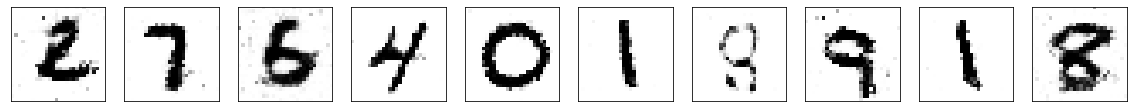

In [34]:
plot_images(generated_images)